# Time series plotting around reservoirs

## To-dos
- [ ] point_subset functions to codebase
- [ ] trend maps for xarray data
- [ ] area_subset of GRACE data (instead of point subset)
- [ ] area_subset of IMERG data
- [ ] area_subset of precip data
- [ ] time series metrics to function

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
!pwd
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets

/global/home/users/ann_scheliga/CYGNSS-GRACE/notebooks


In [3]:
fw = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip = load_data.load_IMERG()

In [10]:
def single_timeseries_IMERG_CYGNSS_GRACE(coords_i,**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`
    
    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip , fw , grace_dict
    precip_full = area_subsets.precip_point_subset(coords_i,precip)
    fw_full = area_subsets.cygnss_point_subset(coords_i,fw)
    cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)
    
    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (12,6)

    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)
    
    return precip , fw , cmwe

In [11]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM
7162,Nuozhadu,China,Hydroelectricity,2014,23703.0
7213,Xiaowan,China,Hydroelectricity,2012,15043.0
5132,Nam Ngum,Laos,Hydroelectricity,1972,7030.0
6946,Nam Ngum 2,Laos,Hydroelectricity,2011,4230.0
6948,Xe Kaman 1,Laos,Hydroelectricity,2015,3210.0
6944,Nam Theun 2,Laos,Hydroelectricity,2010,3210.0
5145,Ubol Ratana,Thailand,Irrigation,1966,2263.0
5792,Sirindhorn,Thailand,Hydroelectricity,1971,1966.0
7232,Lower Sesan II,Cambodia,Hydroelectricity,2017,1790.0
5146,Lam Pao,Thailand,Irrigation,1969,1430.0


In [12]:
area_subsets.reservoir_name_to_point('indirasagar',res_shp)

(22.282538, 76.471948)

In [13]:
res_coords_dict = {
    'merowe' : (18.68 , 32.06),
    'indirasagar' : (22.18,76.6),
    'estreito' : (-6.50001 ,-47.0)
}

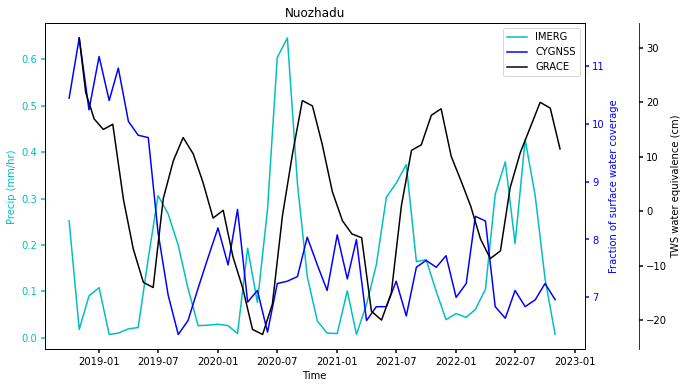

In [14]:
res_oi = 'Nuozhadu'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(area_subsets.reservoir_name_to_point(res_oi,res_shp),**plot_params)

In [1]:
## TESTING phase, idk if this works
def gpd_map_prep(input_ts,input_polys):
    tws = input_ts.T
    x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
    y_tws = tws
    initial_tws_slopes = time_series_calcs.linregress_wrap(x_tws,y_tws)
    initial_tws_slopes_gdf = gpd.GeoDataFrame(pd.concat([initial_tws_slopes , input_polys],axis=1))
    input_gdf = initial_tws_slopes_gdf
    return input_gdf

           slope   intercept   r_value   p_value   std_err
labels                                                    
1426   -0.043903   88.705977 -0.039623  0.563379   0.07586
1427    -0.12197  245.336515 -0.117468  0.085735  0.070652
1428   -0.089652  180.387377 -0.093474  0.172064  0.065429
1429    0.247977 -496.908976  0.199375  0.003326  0.083511
1430    0.111738 -223.571149  0.096674  0.157785  0.078825


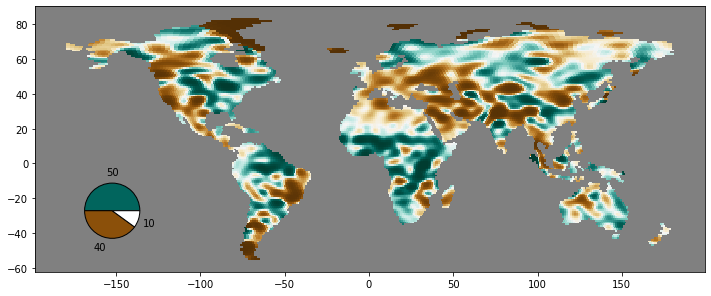

In [ ]:
## Trying out plotting functionality

tws = grace_dict['cmwe'].T
x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
y_tws = tws
initial_tws_slopes = time_series_calcs.linregress_wrap(x_tws,y_tws)
print(initial_tws_slopes.head())

initial_tws_slopes_gdf = gpd.GeoDataFrame(pd.concat([initial_tws_slopes , grace_dict['mascon']],axis=1))

fig , ax = plt.subplots(figsize=(12,8))
input_gdf = initial_tws_slopes_gdf
count = 0
plotting_functions.statsig_map(input_gdf,ax,count, pie_row = [0.5,0.4,0.1])

In [15]:
coords_oi = reservoir_name_to_point('Nouzhadu')

test = grace_point_subset(coords_oi)
print(test[1].iloc[0]['geometry'].exterior)
test[1]['geometry'].explore()

Dam name not found


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
precip_ts = precip_series
fw_ts = fw_series
cmwe_ts = cmwe_series
precip_ts.index = list(map(toYearFraction,precip_ts.index))
fw_ts.index = list(map(toYearFraction,fw_ts.index))
cmwe_ts.index = list(map(toYearFraction,cmwe_ts.index))

In [ ]:
precip_ts = time_series_calcs.TimeSeriesMetrics(precip_ts,'IMERG')
fw_ts = time_series_calcs.TimeSeriesMetrics(fw_ts,'CYGNSS')
cmwe_ts = time_series_calcs.TimeSeriesMetrics(cmwe_ts,'GRACE')

In [ ]:
precip_ts.cross_corr(fw_ts)

TypeError: 'TimeSeriesMetrics' object is not subscriptable

---coef of determination----
Between IMERG and CYGNSS
-311.1120714032106
---coef of determination----
Between IMERG and GRACE
-5241.484921902364
---coef of determination----
Between CYGNSS and IMERG
-0.08242628308416733
---coef of determination----
Between CYGNSS and GRACE
-16.829725985132992
---coef of determination----
Between GRACE and IMERG
0.01024049505463076
---coef of determination----
Between GRACE and CYGNSS
0.029379640492621317


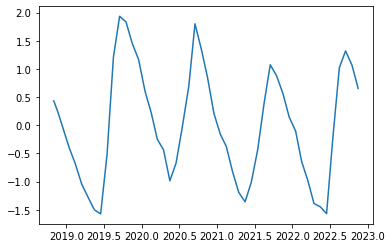

In [ ]:
fig , ax = plt.subplots()
cmwe_ts.plot_anomalies(ax=ax)
precip_ts.coef_determination(fw_ts)
precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);